In [195]:
import os
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import haiku as hk
import jax
import jax.numpy as jnp
import jax.random as jr 
import jraph
import optax
import numpy as np
import matplotlib.pyplot as plt

In [196]:
from get_mnist import load_mnist
from mnist_to_graphs import (
  get_mnist_graphs, 
  get_rotated_mnist_graphs,
  pad_graph_to_value)

#### globals

In [197]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple

N_GRAPHS = 1024
BATCH_SIZE = 16
N_STEPS = 5_000
PAD_VALUE = 8128 
R_LINK = 0.15 #2. #1.5
F = 8
E = 8

#### data

In [198]:
def get_R_z_string(R_values, z_values, n_moments_calculate=3):
    if isinstance(R_values, list):
        if len(R_values) == len(all_R_values):
            R_string = "all"
        else:
            R_string = "_".join([str(float(R)) for R in R_values])
    else:
        R_string = str(R_values)
    if isinstance(z_values, list):
        if len(z_values) == len(all_redshifts):
            z_string = "all"
        else:
            z_string = "_".join([str(float(z)) for z in z_values])
    else:
        z_string = str(z_values)

    return f"x={resolution}_R={R_string}_z={z_string}_nm={n_moments_calculate}"

prng_seq = hk.PRNGSequence(0)

data_dir = "/Users/Jed.Homer/phd/lfi/jaxdelfi/data/"
resolution = 1024 
all_redshifts = [0., 0.5, 1., 2., 3.]
all_R_values = ["5.0", "10.0", "15.0", "20.0", "25.0", "30.0"]

redshifts = all_redshifts[:3]
R_values = all_R_values[:4]

R_idx = [all_R_values.index(R) for R in R_values]
z_idx = [redshifts.index(z) for z in redshifts]

print(f"Running for redshifts:\n{redshifts}\nat resolution x={resolution} with R values:\n{R_values}.")

Rz_string = get_R_z_string(R_values, redshifts, n_moments_calculate=3)

Running for redshifts:
[0.0, 0.5, 1.0]
at resolution x=1024 with R values:
['5.0', '10.0', '15.0', '20.0'].


#### data
* for each moments datavector, make fully connected subgraph for each redshift, then concatenate all the redshift graphs together...

In [199]:
alpha = jnp.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
parameters = jnp.load(
        os.path.join(data_dir, f"ALL_PDFS_PARAMS.npy")) 
simulations = jnp.load(
    os.path.join(data_dir, f"CALCULATED_PDF_MOMENTS_{Rz_string}.npy"))
fiducial_dv = jnp.load(
    os.path.join(data_dir, f'fiducial_moments_unflat_{Rz_string}.npy')).mean(axis=0)

n_sims, parameter_dim = parameters.shape
data_dim = np.prod(fiducial_dv.shape)

parameters.shape, simulations.shape, fiducial_dv.shape

((2000, 5), (2000, 3, 4, 3), (3, 4, 3))

In [200]:
import numpy as np

def make_subgraphs(moments, parameters):
    # Vmapping, so this is z-axis
    all_g_z = []
    for mz in moments:
        # print(mz.shape, np.prod(mz.shape))
        g_z = jraph.get_fully_connected_graph(
            node_features=mz.flatten(),
            n_node_per_graph=np.prod(mz.shape),
            n_graph=1,
            #global_features=parameters, # maybe just parameters for main_graph not subgraphs?
            add_self_edges=True)
        all_g_z.append(g_z)
    return all_g_z 

def make_graph_from_subgraphs(subgraphs, parameters):
    # make one graph from fully connected redshift-subgraphs
    return jraph.GraphsTuple(
        nodes=jnp.concatenate([g_z.nodes for g_z in subgraphs]),
        edges=None,# edges=jnp.concatenate([g_z.edges for g_z in subgraphs]), # edge FEATURES not senders/receivers
        # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
        senders=jnp.concatenate([g_z.n_node * n + g_z.senders for n, g_z in enumerate(subgraphs)]),
        receivers=jnp.concatenate([g_z.n_node * n + g_z.receivers for n, g_z in enumerate(subgraphs)]),
        # senders=jnp.concatenate([g_z.senders for g_z in subgraphs]),
        # receivers=jnp.concatenate([g_z.receivers for g_z in subgraphs]),
        n_node=sum([g_z.n_node for g_z in subgraphs]),
        n_edge=sum([g_z.n_edge for g_z in subgraphs]),
        globals=parameters)

In [201]:
subgraphs = make_subgraphs(fiducial_dv, alpha[None, :])
main_graph = make_graph_from_subgraphs(subgraphs, alpha)
# print(subgraphs[0])
main_graph.nodes.shape, main_graph.edges, main_graph.globals, main_graph.senders.shape, main_graph.receivers.shape

/Users/Jed.Homer/miniconda3/envs/jraph/lib/python3.10/site-packages/jraph/_src/utils.py:882: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  num_node_features = jax.tree_leaves(node_features)[0].shape[0]


((36,),
 None,
 DeviceArray([0.3175, 0.049 , 0.6711, 0.9624, 0.834 ], dtype=float32),
 (432,),
 (432,))

In [202]:
main_graph.senders.max()

DeviceArray(35, dtype=int32)

In [203]:
# main_graph.senders[:36]

A = np.zeros((36, 36))
# for i in range(36):
#     for j in range(36):

for n in range(36):
    # non-directed graph => if sender then receiver => use only senders?
    print(main_graph.senders[n], main_graph.receivers[n])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2


In [204]:
def adjacency_matrix(sender_indices, receiver_indices, n_nodes=None):
    # Determine the number of nodes in the graph if not provided
    if n_nodes is None:
        n_nodes = max(max(sender_indices), max(receiver_indices)) + 1

    # Create an empty adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))

    # Set entries in the adjacency matrix for each edge
    for sender, receiver in zip(sender_indices, receiver_indices):
        adj_matrix[sender, receiver] = 1 
        adj_matrix[receiver, sender] = 1 

    return adj_matrix

In [205]:
# A = adjacency_matrix(subgraphs[0].senders, subgraphs[0].receivers)
# print(A)
# plt.imshow(A)

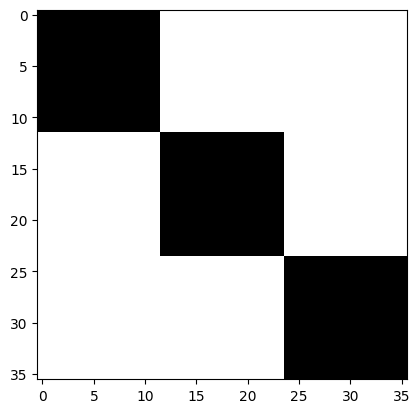

In [206]:
# Expect three squares on diagonal: FULLY connected subgraphs
A = adjacency_matrix(main_graph.senders, main_graph.receivers)
plt.imshow(A, cmap="gray_r")
plt.show()

#### model

##### resnet

In [207]:
layernorm_kwargs = dict(axis=1, create_scale=True, create_offset=True)

class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = jax.nn.leaky_relu,
    activate_final: bool = False):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final

  def __call__(self, x):
    # assert x.shape[-1] == self.hidden_size, (
    #   "Input must be hidden size.")
    z = x
    for f in self.hidden_sizes:
      h = self.activation(z)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f)(h)
      h = self.activation(h)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f, w_init=jnp.zeros)(h)
      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [208]:
@jraph.concatenated_args
def edge_update_fn(feats: Array) -> Array:
  """ Edge update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
    # hk.Linear(F), hk.nets.MLP([F, F, F])])
  return net(feats)

@jraph.concatenated_args 
def node_update_fn(feats: Array) -> Array:
  """ Node update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
    # hk.Linear(F), hk.nets.MLP([F, F, F])])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: Array) -> Array:
  """ Global update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), 
    #LinearResNet([F, F, F], activate_final=True),
    hk.nets.MLP([F, F, F], activate_final=True),
    hk.Linear(parameter_dim, with_bias=False)]) # output summary of parameter dim
  return net(feats)

def LayerNormLinear(x):
    return hk.Linear(E, with_bias=False)(hk.LayerNorm(**layernorm_kwargs)(x))

def net_fn(graph: Graph) -> Graph:
  """ 
    Default aggregator functions for edges, global edges, global nodes 
    are "segment_sum"
  """
  embedder = jraph.GraphMapFeatures(
    # embed_edge_fn=LayerNormLinear, #hk.Linear(E, with_bias=False), 
    embed_node_fn=LayerNormLinear, #hk.Linear(E, with_bias=False), 
    embed_global_fn=LayerNormLinear) #hk.Linear(E, with_bias=False))
  net = jraph.GraphNetwork(
    update_node_fn=node_update_fn,
    # update_edge_fn=edge_update_fn,
    update_edge_fn=None,
    update_global_fn=update_global_fn)
  graph = embedder(graph)
#   for _ in range(3):
  graph = net(graph)
  return graph
  #return net(embedder(graph)) 

#### train

#### trainer functions

In [209]:
dataset_processed = []
for n in range(N_GRAPHS):
    g = make_graph_from_subgraphs(
        make_subgraphs(
            simulations[n], parameters[n]), parameters[n])
    l = parameters[n]
    dataset_processed.append(dict(input_graph=g, target=l))

In [210]:
gs, ls = [], []
for _ in range(5):
    gl = dataset_processed[_]
    g, l = gl.values()
    gs.append(g), ls.append(l)

g_all = jraph.batch(gs)
print([g.nodes.shape for g in gs])
g_all.nodes.shape
g_all.n_node

[(36,), (36,), (36,), (36,), (36,)]


DeviceArray([36, 36, 36, 36, 36], dtype=int32)

In [211]:
def compute_loss(
  params: hk.Params, 
  graph: Graph, 
  label: Array,
  net: Graph) -> Tuple[Array, Array]:
  """Computes loss and accuracy."""

  pred_graph = net.apply(params, graph)
  print("pred graph globals", pred_graph.globals.shape)

  # Output of GNN and target: one hot encoded MNIST labels
  # preds = jax.nn.log_softmax(pred_graph.globals)
  preds = pred_graph.globals

  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  print("PREDS/TARGETS", preds.shape, label.shape)
  # loss = -(preds * label * mask[:, None]).mean()
  loss = (jnp.square(jnp.subtract(preds, label)) * mask[:, None]).mean()

  return loss, (None,)
 

def train(
  dataset: List[Dict[str, Any]], 
  num_train_steps: int) -> Tuple[hk.Params, List, List]:

  key = jr.PRNGKey(0)

  net = hk.without_apply_rng(hk.transform(net_fn))

  graph = dataset[0]['input_graph']
  graph = pad_graph_to_value(graph, PAD_VALUE)
  params = net.init(key, graph)

  print(f"n_params = {sum(x.size for x in jax.tree_util.tree_leaves(params)):.2E}")

  # Initialize the optimizer.
  opt_init, opt_update = optax.adabelief(2e-4)
  opt_state = opt_init(params)

  compute_loss_fn = partial(compute_loss, net=net)
  compute_loss_fn = jax.jit(
    jax.value_and_grad(compute_loss_fn, has_aux=True))

  losses, accs = [], []
  for _ in range(num_train_steps):
    key, key_idx = jr.split(key)

    if BATCH_SIZE > 1:
        idx = jr.randint(key_idx, shape=(BATCH_SIZE,), minval=0, maxval=N_GRAPHS)
        gs, ls = [], []
        for i in idx:
            g, l = dataset[int(i)].values()
            gs.append(g), ls.append(l)
        graph = jraph.batch(gs)
        label = jnp.concatenate(ls)
    else:
        idx = int(jr.randint(key_idx, shape=(BATCH_SIZE,), minval=0, maxval=N_GRAPHS))
        graph, label = dataset[idx].values()

    """ Should remove graph label, for model to generate itself. """
    # graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
    graph = pad_graph_to_value(graph, PAD_VALUE)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    """ This label gets masked out. """
    label = jnp.concatenate([label, jnp.zeros((1, parameter_dim))])

    (loss, (acc, pred)), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

    if _ % 100 == 0:
      print(f'\rstep: {_:06d}, ' +
            f'loss: {loss:.4f}, ' + 
            f'acc: {100. * acc:.4f}% ' + 
            f'l: {label.argmax(axis=1)} ' +
            f'l_: {pred}', end="")
    losses.append(loss)
    accs.append(acc)

  print('Training finished')
  return params, losses, accs


def evaluate(
  dataset: List[Dict[str, Any]],
  params: hk.Params) -> Tuple[Array, Array]:

  # Transform impure `net_fn` to pure functions with hk.transform.
  net = hk.without_apply_rng(hk.transform(net_fn))

  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']

  accumulated_loss = 0.
  accumulated_accuracy = 0.

  compute_loss_fn = jax.jit(partial(compute_loss, net=net))
  for idx in range(len(dataset)):
    graph = dataset[idx]['input_graph']
    label = dataset[idx]['target']

    graph = pad_graph_to_value(graph, PAD_VALUE)
    label = jnp.concatenate([label, jnp.zeros((1, parameter_dim))])

    graph = net.apply(params, graph)

    loss, acc = compute_loss_fn(params, graph, label)

    accumulated_accuracy += acc
    accumulated_loss += loss

    if idx % 100 == 0:
      print(f'Evaluated {idx + 1} graphs')

  print('Completed evaluation.')
  loss = accumulated_loss / idx
  accuracy = accumulated_accuracy / idx
  print(f'Eval loss: {loss:.4f}, accuracy {accuracy:.4f}')
  return loss, accuracy

#### check

In [212]:
key = jr.PRNGKey(0)
key, _ = jr.split(key)

net = hk.without_apply_rng(hk.transform(net_fn))

ix1, ix2 = jr.randint(key, (2,), 0, len(dataset_processed))

graph = dataset_processed[ix1]['input_graph']
l = dataset_processed[ix1]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print(graph.globals)

print(graph.globals)

params = net.init(key, graph)

graph = dataset_processed[ix2]['input_graph']
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)

y_ = net.apply(params, graph)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print(mask)

jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[0.4157  0.04765 0.6087  0.8165  0.9189  0.     ]
[0.4157  0.04765 0.6087  0.8165  0.9189  0.     ]


ValueError: Incompatible shapes for broadcasting: (2,) and requested shape (8,)

In [ ]:
graph = dataset_processed[ix2]['input_graph']
print("before pad", graph.nodes.shape, graph.edges.shape, graph.globals.shape)
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print("after pad", graph.nodes.shape, graph.edges.shape, graph.globals.shape)

before pad (64, 1) (372, 3) (1, 10)
after pad (8129, 1) (8128, 3) (2, 10)


In [ ]:
params, losses, accs = train(dataset_processed, num_train_steps=N_STEPS)

n_params = 5.98E+04
pred graph globals (9, 10)
PREDS/TARGETS (9, 10) (9, 10)
pred graph global Traced<ShapedArray(int32[9])>with<DynamicJaxprTrace(level=0/1)>
label Traced<ShapedArray(int32[9])>with<DynamicJaxprTrace(level=0/1)>
step: 004900, loss: 0.0285, acc: 87.5000 l: [9 1 1 4 1 2 1 7 0] l_: [9 1 1 4 1 0 1 7 1]]Training finished


NameError: name 'losses' is not defined

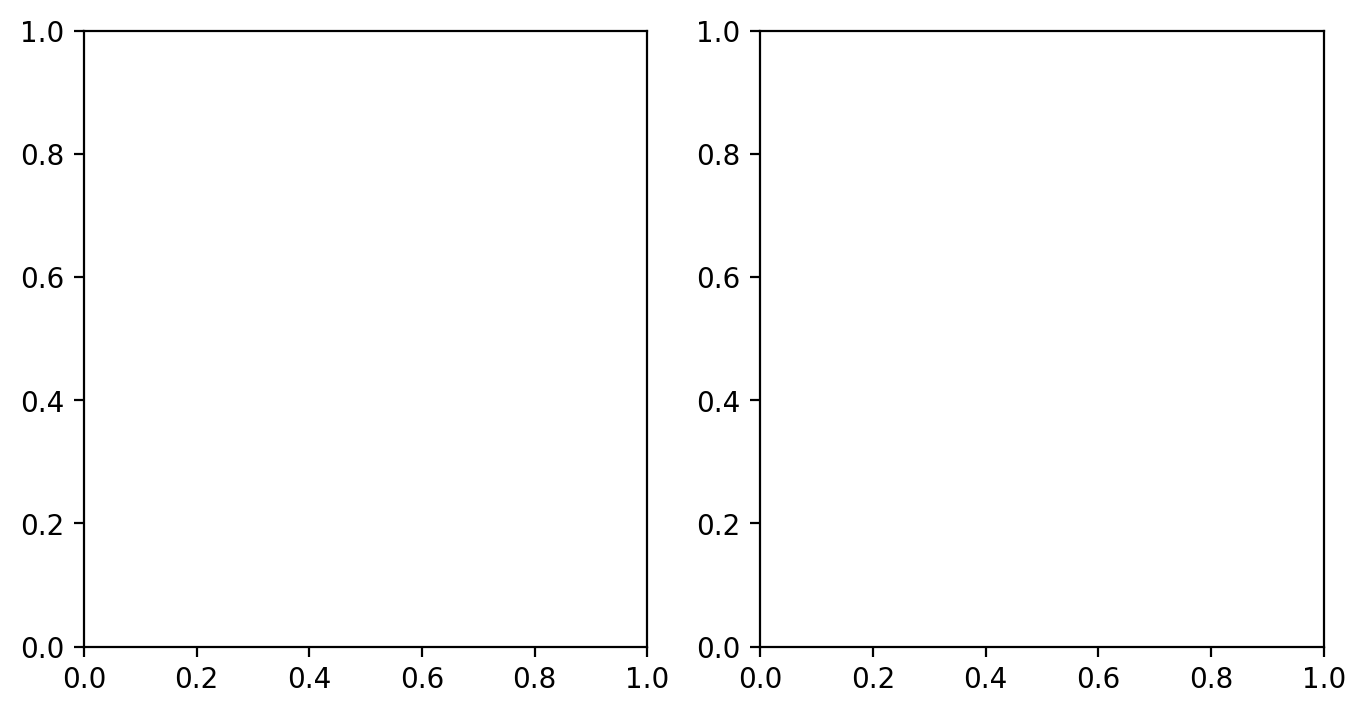

In [ ]:
fig, axs = plt.subplots(1, 2, dpi=200, figsize=(8.,4.))
ax = axs[0]
steps = range(0, N_STEPS, 10)
ax.semilogy(steps, losses[::10])
ax = axs[1]
steps = range(0, N_STEPS, 40)
ax.plot(steps, accs[::40])
plt.show()

In [ ]:
evaluate(dataset_processed, params)

label [5 0] [8 9]


ValueError: 'linear_1/w' with retrieved shape (1, 32) does not match shape=[32, 32] dtype=dtype('float32')

In [ ]:
c, n = 0, 0
total_accuracy = 0.
for _ in range(len(dataset)):

    x = dataset_processed[_]["input_graph"]
    label = dataset_processed[_]["target"]
    #x = pad_graph_to_nearest_power_of_two(x)
    x = pad_graph_to_value(x, PAD_VALUE)
    # label = jnp.concatenate([label, jnp.array([0])])

    y_ = net.apply(params, x)
    mask = jraph.get_graph_padding_mask(y_)

    accuracy = jnp.sum(     
        (jnp.argmax(y_.globals, axis=1) == label) * mask) / jnp.sum(mask)
    print(f"{jnp.argmax(y_.globals, axis=1)[0]} {int(dataset[_]['target'])}")

    total_accuracy += accuracy

    total_accuracy /= _
    print(f"ACCURACY = {total_accuracy:.2f}%")

    # Try rotating the graph to test invariance of classification
    print("TESTING ROTATION INVARIANCE.")
    key = jr.PRNGKey(1294)
    n_test = 10
    ix = jr.randint(key, shape=(n_test,), minval=0, maxval=n_test)
    dataset = get_rotated_mnist_graphs(
    X[ix], Y[ix], n_graphs=n_test, r_link=R_LINK, plot=True)

    for i in range(n_test):
        x, y = dataset_processed[i]["input_graph"], dataset_processed[i]["target"]
        x = pad_graph_to_value(x, PAD_VALUE)
        # label = jnp.concatenate([y, jnp.array([0])])

        y_ = net.apply(params, x)
        mask = jraph.get_graph_padding_mask(y_) 

        # accuracy = jnp.sum(     
        #     (jnp.argmax(y_.globals, axis=1) == y) * mask) / jnp.sum(mask)

        # no mask, globals stay same size always?
        accuracy = jnp.sum(jnp.argmax(y_.globals, axis=1) == y) 
        print(f"{jnp.argmax(y_.globals, axis=1)[0]} {int(dataset[i]['target'])}")

ValueError: Incompatible shapes for broadcasting: shapes=[(2,), (1, 10)]